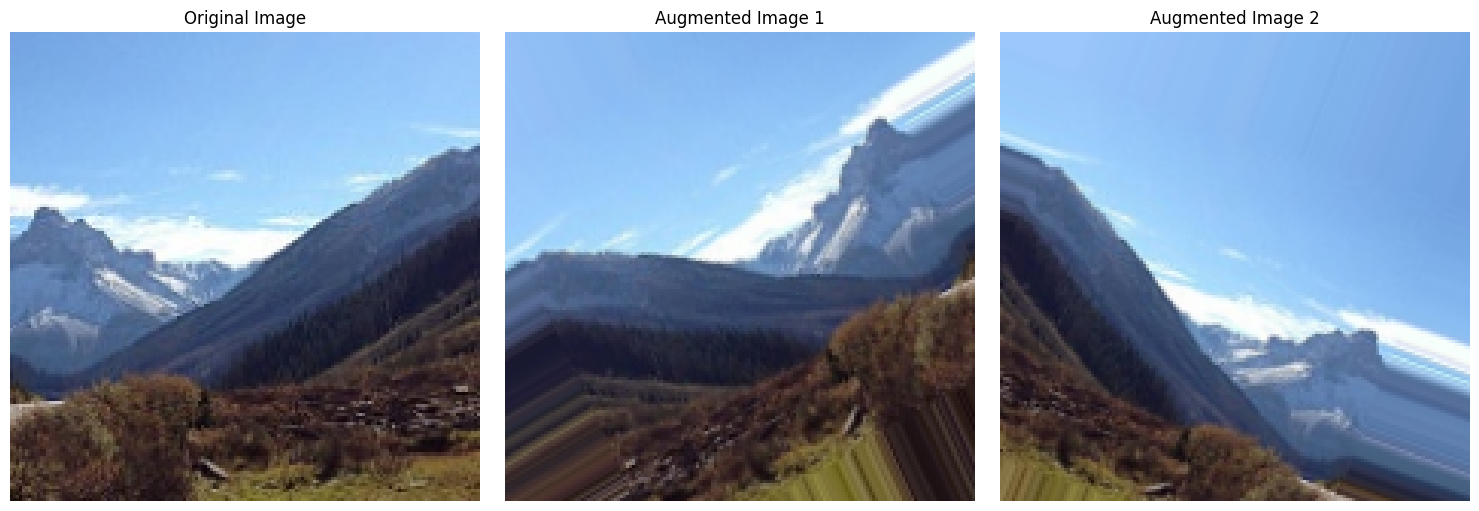

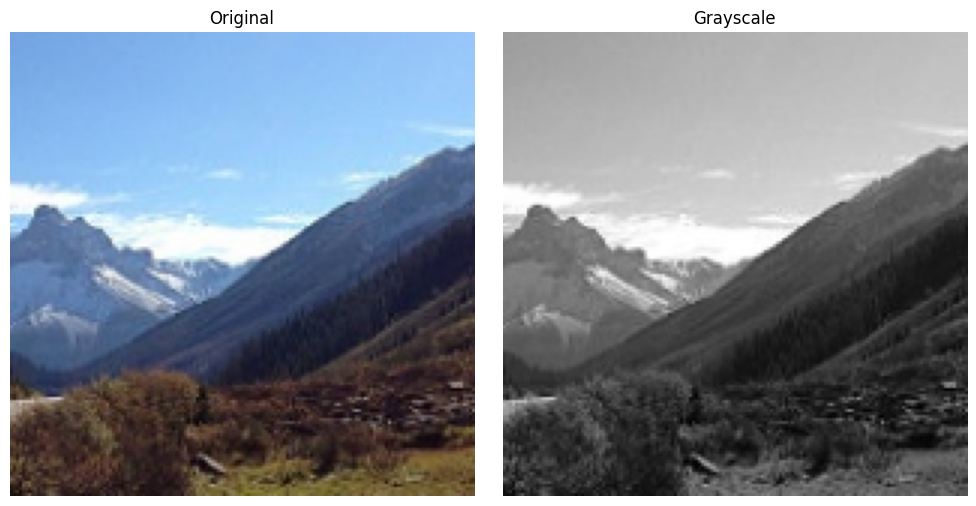

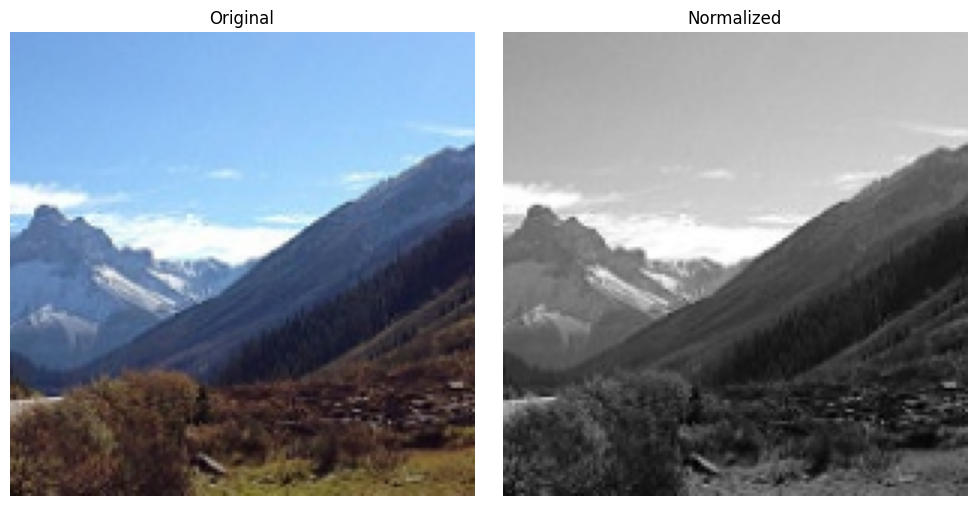

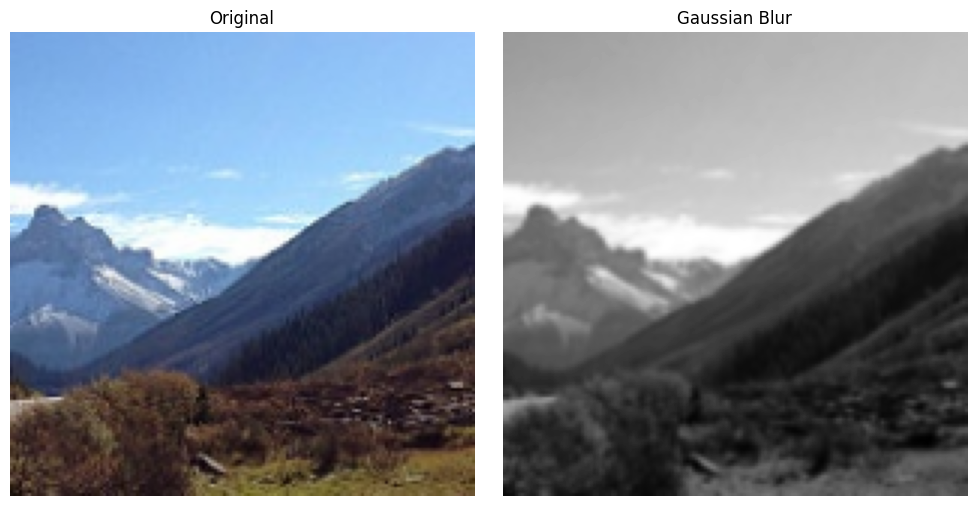

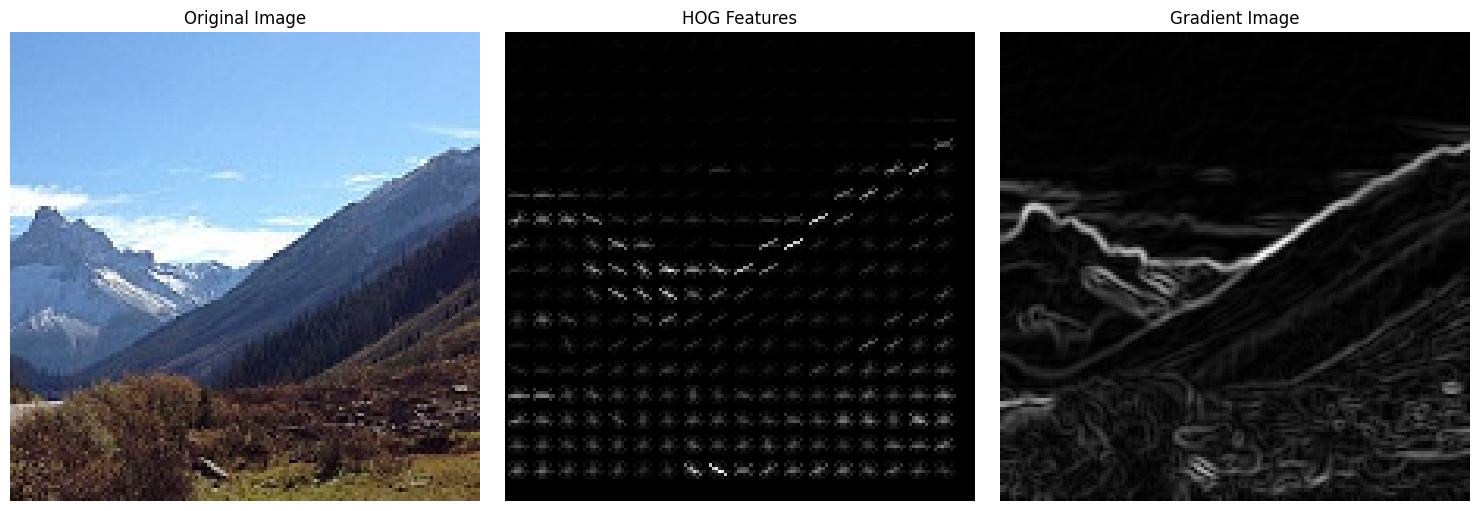

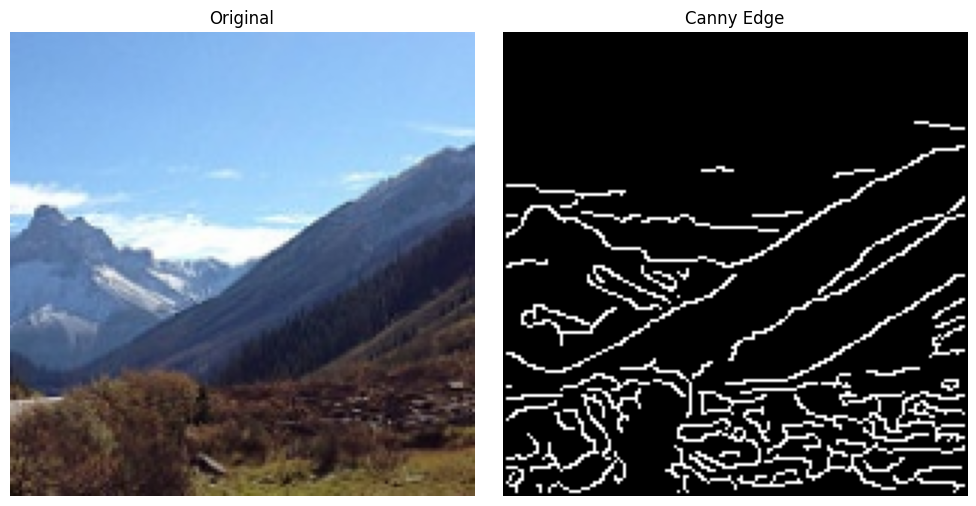

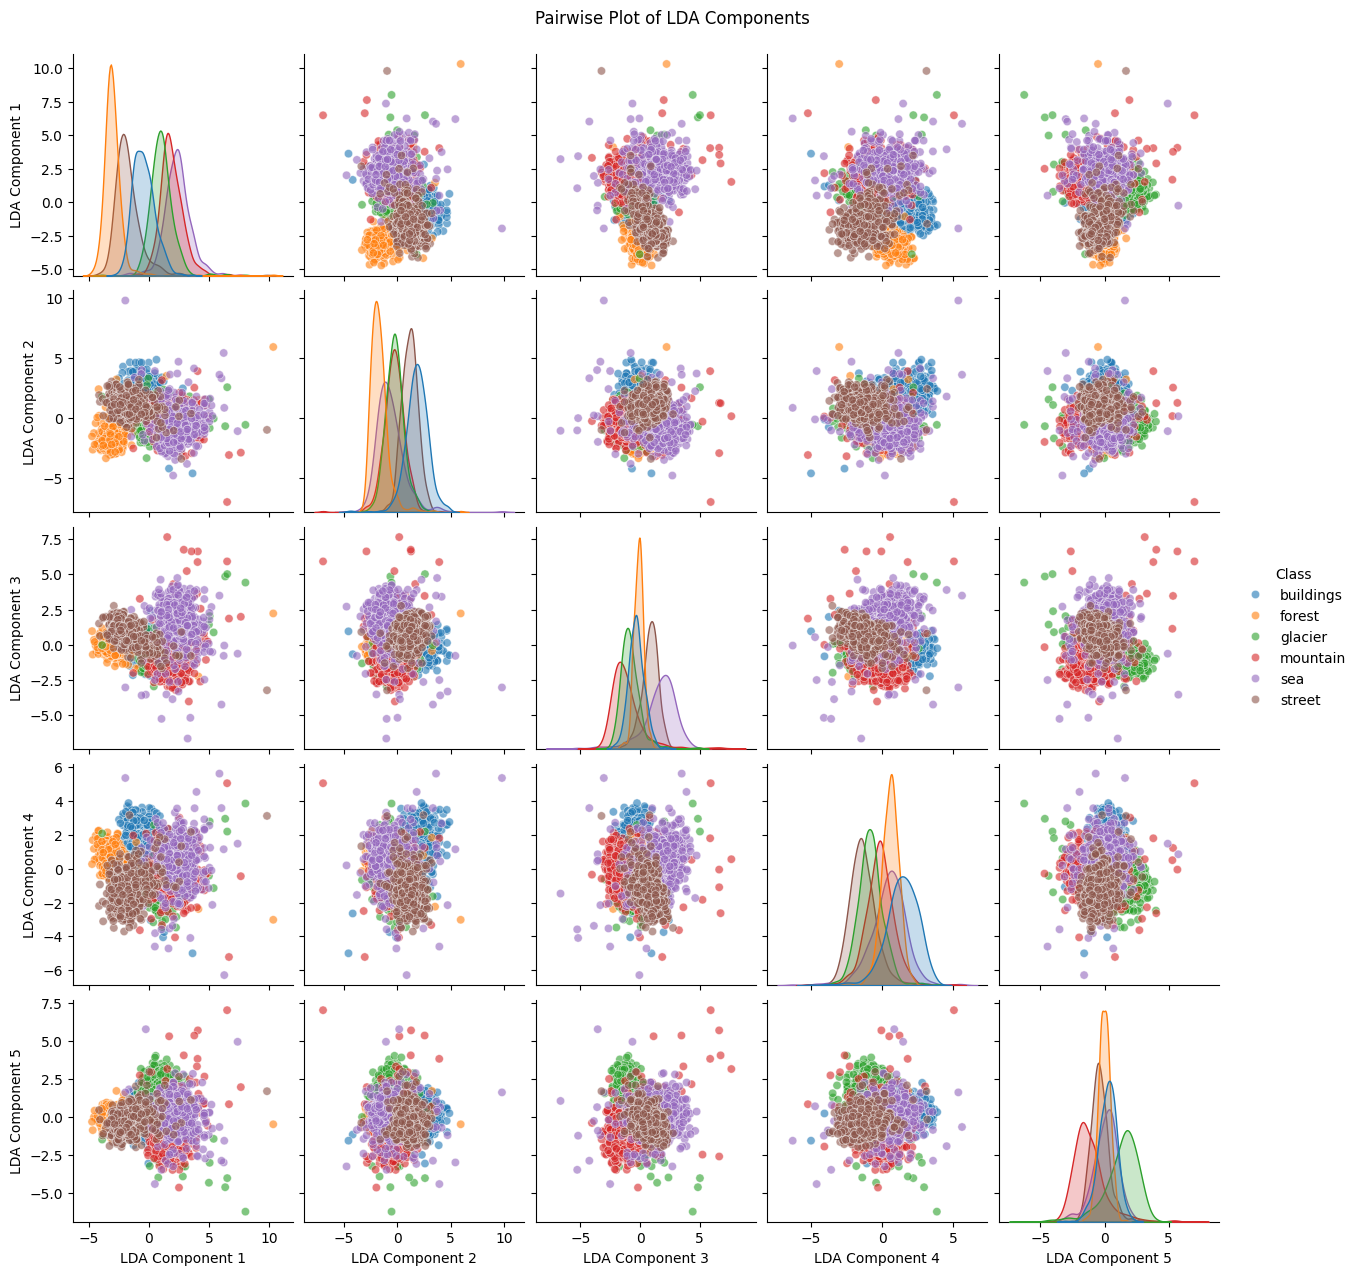

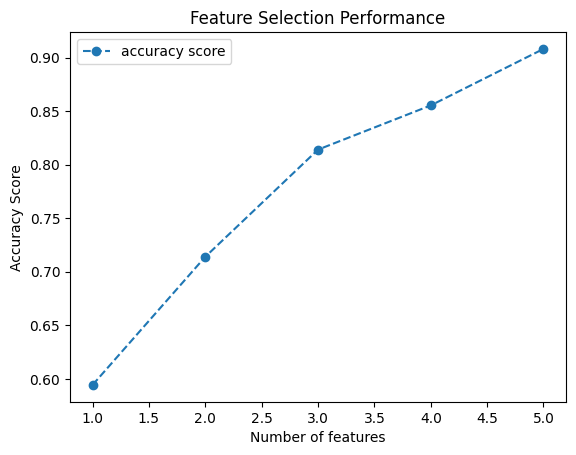

Best number of features: 5 with a accuracy score of 0.91


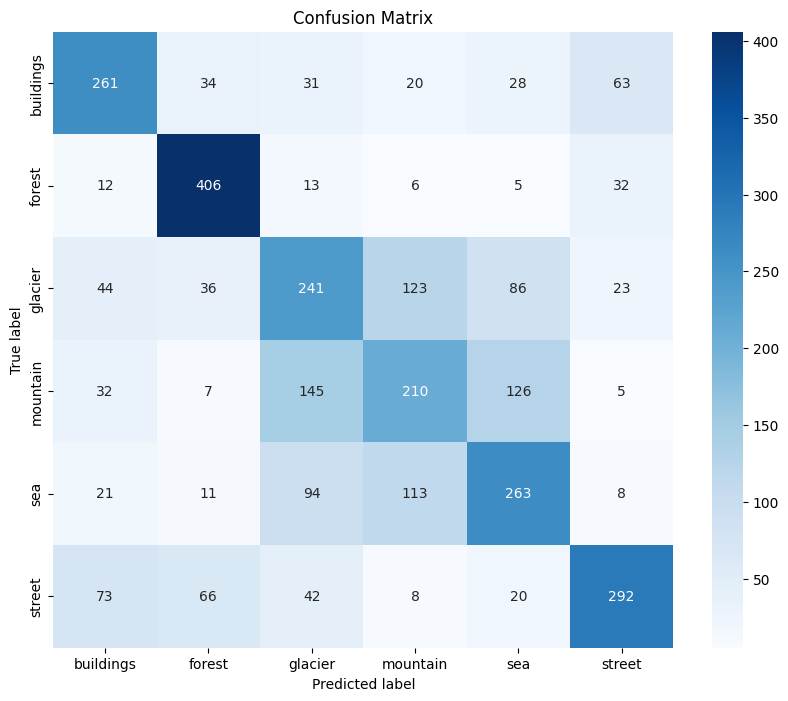


Classification Report:
buildings       0.59 0.60 0.59 437.0
forest          0.72 0.86 0.79 474.0
glacier         0.43 0.44 0.43 553.0
mountain        0.44 0.40 0.42 525.0
sea             0.50 0.52 0.51 510.0
street          0.69 0.58 0.63 501.0
macro avg       0.56 0.56 0.56 3000.0
weighted avg    0.56 0.56 0.55 3000.0

Training time: 0.07 seconds
Inference time: 0.29 seconds
Compute device: CPU
Model size: 0.03 MB
Number of parameters: 5


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, exposure, feature, filters
from skimage.transform import resize
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import time
import cv2
import pandas as pd
from skimage import color, data
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def preprocess_image(image_path, target_size=(155, 155)):
    img = io.imread(image_path)
    img_resized = resize(img, target_size, anti_aliasing=True)
    img_gray = color.rgb2gray(img_resized)
    img_normalized = exposure.rescale_intensity(img_gray, out_range=(0, 1))
    img_blurred = filters.gaussian(img_normalized, sigma=0.75)
    hog_features, hog_image = hog(img_blurred, orientations=10, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    edges = feature.canny(img_blurred)
    # Flatten and concatenate features
    feature_vector = np.concatenate([hog_features, edges.flatten()])
    return img_resized, img_gray, img_normalized, img_blurred, hog_image, edges, feature_vector

def load_dataset(data_dir, augment=True):
    features = []
    labels = []
    datagen = None

    if augment:
        # Define data augmentation using ImageDataGenerator
        datagen = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir)[:553]:  # Adjust as needed
                image_path = os.path.join(class_dir, image_name)
                try:
                    img_resized, img_gray, img_normalized, img_blurred, hog_image, edges, feature_vector = preprocess_image(image_path)
                    
                    # Add original image features to the list
                    features.append(feature_vector)
                    labels.append(label)
                    
                    if augment:
                        # Reshape the image to be compatible with the ImageDataGenerator
                        img_resized = img_resized.reshape((1, *img_resized.shape))
                        augmented_images = datagen.flow(img_resized, batch_size=1)

                        # Generate a specified number of augmented images
                        for i in range(2):  # Adjust number of augmented images as needed
                            augmented_image = next(augmented_images)[0]  # Get the augmented image
                            _, _, _, _, _, _, aug_feature_vector = preprocess_image(image_path)
                            features.append(aug_feature_vector)
                            labels.append(label)

                except Exception as e:
                    print(f"Error processing image {image_path}: {e}")
    
    features = np.array(features)
    labels = np.array(labels)
    return features, labels

def train_svm(X_train, y_train, X_test, y_test):
    svm = SVC(kernel='rbf', C=1.0, random_state=42)
    start_time = time.time()
    svm.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = svm.predict(X_test)
    inference_time = time.time() - start_time
    
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    return svm, cm, report, training_time, inference_time

def plot_preprocessing_step(original, processed, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(processed, cmap='gray')
    ax2.set_title(title)
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

def plot_hog(image_path):

    def compute_hog_features(original_image):
        gray_image = color.rgb2gray(original_image)
        return hog(
            gray_image, 
            orientations=9, 
            pixels_per_cell=(8, 8), 
            cells_per_block=(1, 1), 
            visualize=True
        )

    def compute_gradient_image(image):
        # Convert image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Compute gradients
        grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
        grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
        
        # Combine gradients
        gradient_image = cv2.magnitude(grad_x, grad_y)
        
        return gradient_image

    # Read the image
    image = io.imread(image_path)
    
    # Compute HOG features
    fd, hog_image = compute_hog_features(image)
    
    # Compute gradient image
    gradient_image = compute_gradient_image(image)
    
    # Plot the results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Plot HOG image
    axes[1].imshow(hog_image, cmap='gray')
    axes[1].set_title('HOG Features')
    axes[1].axis('off')
    
    # Plot gradient image
    axes[2].imshow(gradient_image, cmap='gray')
    axes[2].set_title('Gradient Image')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def visualize_lda_reduction(X_train_scaled, X_test_scaled, y):
    # Fit LDA and transform the data
    lda = LinearDiscriminantAnalysis()
    X_lda = lda.fit_transform(X_train_scaled, y)
    X_test_lda = lda.transform(X_test_scaled)

    # Convert the LDA results to a DataFrame
    df_lda = pd.DataFrame(X_lda, columns=[f'LDA Component {i+1}' for i in range(X_lda.shape[1])])
    df_lda['Class'] = y

    # Create a pairplot using seaborn
    sns.pairplot(df_lda, hue='Class', diag_kind='kde', plot_kws={'alpha': 0.6})
    plt.suptitle('Pairwise Plot of LDA Components', y=1.02)
    plt.show()

    return X_lda, X_test_lda

    return X_lda, X_test_lda

def plot_feature_selection(X, y, metric='accuracy'):
    """
    Plots the performance of feature selection for different numbers of features.
    
    Parameters:
    X (np.ndarray): Feature matrix.
    y (np.ndarray): Labels.
    metric (str): The metric to evaluate the performance ('accuracy', 'f1', 'precision', 'recall').
    """
    n_features_range = range(1, X.shape[1] + 1)
    best_score = 0
    best_selector = None
    best_n_features = 0
    
    scores = []

    for n in n_features_range:
        selector = SelectKBest(f_classif, k=n)
        X_selected = selector.fit_transform(X, y)
        svm = SVC(kernel='rbf', C=1.0, random_state=42)
        svm.fit(X_selected, y)
        y_pred = svm.predict(X_selected)

        # Calculate the chosen metric
        if metric == 'accuracy':
            score = accuracy_score(y, y_pred)
        elif metric == 'f1':
            score = f1_score(y, y_pred, average='weighted')
        elif metric == 'precision':
            score = precision_score(y, y_pred, average='weighted')
        elif metric == 'recall':
            score = recall_score(y, y_pred, average='weighted')
        else:
            raise ValueError("Invalid metric specified. Choose from 'accuracy', 'f1', 'precision', 'recall'.")
        
        scores.append(score)
        
        if score > best_score:
            best_score = score
            best_selector = selector
            best_n_features = n

        # Plot the score for each number of features
        # plt.plot(n_features_range, [score if i == n else None for i in n_features_range], 'o--', label=f'{n} features')
    
    # Plot the performance across all feature counts
    plt.plot(n_features_range, scores, 'o--', label=f'{metric} score')
    plt.xlabel('Number of features')
    plt.ylabel(f'{metric.capitalize()} Score')
    plt.title('Feature Selection Performance')
    plt.legend()
    plt.show()
    
    # Return the best selector
    print(f"Best number of features: {best_n_features} with a {metric} score of {best_score:.2f}")
    return best_selector

def augment_image(image, num_augmented_images=2):
    datagen = ImageDataGenerator(
        rotation_range=30,       # Random rotation between -30 and 30 degrees
        width_shift_range=0.2,   # Horizontal shift
        height_shift_range=0.2,  # Vertical shift
        shear_range=0.2,         # Shear angle
        zoom_range=0.2,          # Random zoom
        horizontal_flip=True,    # Random horizontal flip
        fill_mode='nearest'      # Fill mode for newly created pixels
    )

    # Reshape image to match expected dimensions for ImageDataGenerator
    image = image.reshape((1, *image.shape))

    augmented_images = []
    for i, batch in enumerate(datagen.flow(image, batch_size=1)):
        augmented_images.append(batch[0])
        if i >= num_augmented_images - 1:
            break

    return augmented_images

def plot_original_and_augmented(original_image, augmented_images):
    num_images = len(augmented_images)
    fig, axes = plt.subplots(1, num_images + 1, figsize=(15, 5))

    # Plot the original image
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Plot the augmented images
    for i, augmented_image in enumerate(augmented_images):
        axes[i + 1].imshow(augmented_image, cmap='gray')
        axes[i + 1].set_title(f'Augmented Image {i + 1}')
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

def main():
    data_dir = "../../data/intel-image-classification/seg_train/seg_train"
    test_dir = "../../data/intel-image-classification/seg_test/seg_test"

    # Load training data
    features, labels = load_dataset(data_dir, augment=False)
    X_train = features
    y_train = labels

    # Load test data
    test_features, test_labels = load_dataset(test_dir, augment=False)
    X_test = test_features
    y_test = test_labels

    # Select a sample image for augmentation
    nr = 3  # Sample index for visualizations
    sample_image_path = os.path.join(data_dir, os.listdir(data_dir)[nr], os.listdir(os.path.join(data_dir, os.listdir(data_dir)[nr]))[nr])
    img_resized, img_gray, img_normalized, img_blurred, hog_image, edges, _ = preprocess_image(sample_image_path)

    # Augment the image and plot
    augmented_images = augment_image(img_resized, num_augmented_images=2)
    plot_original_and_augmented(img_resized, augmented_images)

    # Continue with the rest of the pipeline...
    plot_preprocessing_step(img_resized, img_gray, 'Grayscale')
    plot_preprocessing_step(img_resized, img_normalized, 'Normalized')
    plot_preprocessing_step(img_resized, img_blurred, 'Gaussian Blur')
    plot_hog(sample_image_path)
    plot_preprocessing_step(img_resized, edges, 'Canny Edge')
    
    # Visualize LDA reduction
    X_train_lda, X_test_lda = visualize_lda_reduction(X_train, X_test, y_train)

    # Feature selection
    selector = plot_feature_selection(X_train_lda, y_train)

    # Apply the best selector to the training and testing data
    X_train_selected = selector.transform(X_train_lda)
    X_test_selected = selector.transform(X_test_lda)

    # Train SVM on the selected features from LDA-reduced data
    svm, cm, report, training_time, inference_time = train_svm(X_train_selected, y_train, X_test_selected, y_test)
    
    # Plot confusion matrix
    plot_confusion_matrix(cm, np.unique(y_test))
    
    # Print classification report
    print("\nClassification Report:")
    for class_name, metrics in report.items():
        if isinstance(metrics, dict):
            print(f"{class_name:15} {metrics['precision']:.2f} {metrics['recall']:.2f} {metrics['f1-score']:.2f} {metrics['support']}")

    # Print additional information
    print(f"\nTraining time: {training_time:.2f} seconds")
    print(f"Inference time: {inference_time:.2f} seconds")
    print(f"Compute device: CPU")
    print(f"Model size: {svm.get_params()['C'] * X_train_lda.shape[0] * 8 / (1024 * 1024):.2f} MB")
    print(f"Number of parameters: {X_train_lda.shape[1]}")

main()
